In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
import numpy as np
np.set_printoptions(precision=3)
%precision 3

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data()
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False True 100
init /home/franzi/Documents/models/no_pm_no_sw_lowerCase_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_lowerCase_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_4_vecDim100_lowerCase
loading data...
37163 37163 11805 11805 0 0
took:  3.4712915420532227


In [ ]:
import numpy as np
label_y = prepare_training_data.one_hot_to_labels(y_train)

In [4]:
from tensorflow.keras import *

In [5]:
# Build the model
print('Build model...')
from sklearn.neural_network  import MLPClassifier
clf= MLPClassifier(verbose=1, batch_size=32, max_iter=10, learning_rate='adaptive',early_stopping=True)
nsamples, nx, ny = x_train.shape
print(x_train.shape)
x_train2 = x_train.reshape((nsamples,nx*ny))
print(x_train2.shape)
y_train2 = prepare_training_data.one_hot_to_labels(y_train)
clf.fit(x_train2, y_train2)

Build model...
(37163, 9, 100)
(37163, 900)
Iteration 1, loss = 0.61497920
Validation score: 0.823783
Iteration 2, loss = 0.44797920
Validation score: 0.818671
Iteration 3, loss = 0.38271182
Validation score: 0.831047
Iteration 4, loss = 0.33342094
Validation score: 0.838579
Iteration 5, loss = 0.29264496
Validation score: 0.835620
Iteration 6, loss = 0.25836103
Validation score: 0.836696
Iteration 7, loss = 0.22625747
Validation score: 0.844767
Iteration 8, loss = 0.20157951
Validation score: 0.836427
Iteration 9, loss = 0.17669447
Validation score: 0.839925
Iteration 10, loss = 0.15939113
Validation score: 0.829432


MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=10,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [7]:

nsamples, nx, ny = x_test.shape
print(x_test.shape)
x_test2 = x_test.reshape((nsamples,nx*ny))
print(x_test2.shape)
# predict test data
y_pred = clf.predict(x_test2)

(11805, 9, 100)
(11805, 900)


In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = y_pred
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [9]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('Recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.843177 | 0.150943 |    0.498462 |     0.590568 |  0.960199 |      0.730636 |    0.702179 |  0.884775 |
| recall    |     0.766667 | 0.129032 |    0.227848 |     0.523267 |  0.877273 |      0.837086 |    0.814607 |  0.920903 |
| f1        |     0.803104 | 0.13913  |    0.312741 |     0.554884 |  0.916865 |      0.780247 |    0.754226 |  0.902478 |
f1 average:  0.645459414358957
f1 average:  0.5573888168408364
Precision average:  0.6701174337878194
Recall average:  0.6370853293840245
acc 0.8166878441338415


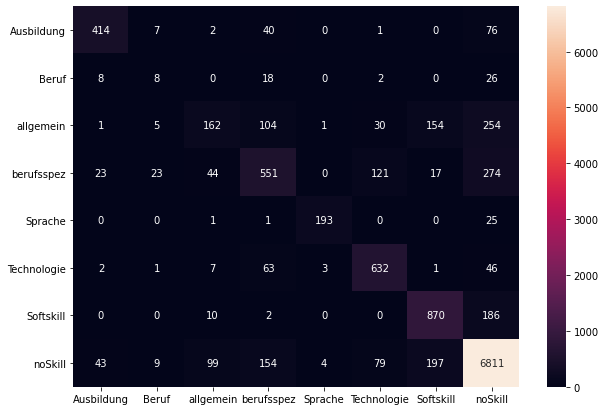

In [10]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [11]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  6811


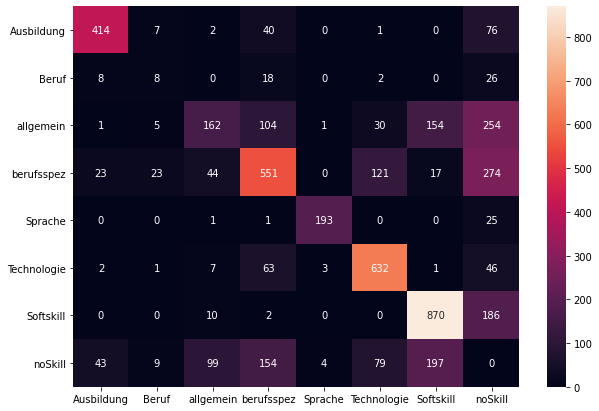

In [12]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [13]:
from word2vec import W2V
correct = []
false = []

clean_x_test, pred_label, true_label, afks = shuffle(clean_x_test, pred_label, true_label, afks,random_state=0)
skill_index = int(len(clean_x_test[0])/2)
label_list = list(labels.keys())


In [14]:
headers = [['|']+[l+'('+str(i)+')'] for i,l in enumerate(label_list) ]
headers = sum(headers, [])
headers.append('|')

wvs = []
for i in range(len(clean_x_test)):
    wvs.append(clean_x_test[i][skill_index])

w2v = W2V(skipgram=True, punctuation_marks=False, stoppwords=False, multiword=False, lower_case=True, vector_dim=100)

predictions = [[],[],[],[],[],[],[], []]
for i in range(len(clean_x_test)):
    word = w2v.get_closest_word_to_vec(wvs[i])[0][0]
    label = str(true_label[i])
    predictions[pred_label[i]].append(word + '('+label+')')

table = []
# format
i = 0
while(i < len(predictions[0]) or i < len(predictions[1]) or i < len(predictions[2]) or i < len(predictions[3]) or i < len(predictions[4]) or i < len(predictions[5] or i < len(predictions[6]))):
    row = ['|']
    for x in predictions:
        if(len(x) > i and len(x[i]) <  28): 
            row.append(x[i])
            row.append('|')
        else:
            row.append('')
            row.append('|')
            
    table.append(row)
    i+=1    

print(tabulate(table, headers=headers))

skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False True 100
init /home/franzi/Documents/models/no_pm_no_sw_lowerCase_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_lowerCase_vecDim100/skip_gram_model.model
|    Ausbildung(0)                |    Beruf(1)                   |    allgemein(2)                 |    berufsspez(3)                |    Sprache(4)                 |    Technologie(5)               |    Softskill(6)                 |    noSkill(7)                   |
---  ---------------------------  ---  -------------------------  ---  ---------------------------  ---  ---------------------------  ---  -------------------------  ---  ---------------------------  ---  ---------------------------  ---  ---------------------------  ---
|    technomathematik(0)          |    softwareentwicklung(3)     |    zimmerstunde(7)              |    steuerungstechnik(3)         |    englis